In [13]:
import os
from pathlib import Path
import logging
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Set up logging and CSV export directories
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = Path("figures/optimizer/logs")
csv_dir = Path("figures/optimizer/csv_exports")
log_dir.mkdir(parents=True, exist_ok=True)
csv_dir.mkdir(parents=True, exist_ok=True)

log_file = log_dir / f"optimizer_analysis_{timestamp}.log"

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler(),  # Also log to console
    ],
)

logger = logging.getLogger(__name__)
logger.info(f"Starting optimizer performance analysis - Log file: {log_file}")
logger.info(f"CSV exports will be saved to: {csv_dir}")

# Get list of all CSV files in the directory
list_of_commits = list(Path("../../logs/performance/analysis").glob("*/"))
list_of_commits.sort(key=os.path.getmtime, reverse=True)
list_of_commits = list_of_commits[:1]

# Initialize an empty DataFrame to store combined results
df_latest = pd.DataFrame()

list_of_files = list(Path(list_of_commits[0] / "all").glob("*.csv"))
logger.info(f"Processing {len(list_of_files)} CSV files from {list_of_commits[0]}")

# For each file in this commit
for file_path in list_of_files:
    # Read the CSV file
    temp_df = pd.read_csv(file_path)
    # Append to the main DataFrame
    df_latest = pd.concat([df_latest, temp_df], ignore_index=True)

# Adjust num_workers: subtract 1 if not 0
df_latest["fainder_max_workers"] = df_latest["fainder_max_workers"].apply(
    lambda x: x - 1 if x != 0 else x
)

# Strip whitespace and normalize the category column
df_latest["category"] = df_latest["category"].str.strip()

logger.info(f"Loaded {len(df_latest)} total records")
logger.info(f"Unique categories: {list(df_latest['category'].unique())}")
logger.info(f"Unique fainder modes: {list(df_latest['fainder_mode'].unique())}")

# Check optimizer columns
optimizer_cols = [
    "optimizer_cost_sorting",
    "optimizer_keyword_merging",
    "optimizer_split_up_junctions",
]
for col in optimizer_cols:
    if col in df_latest.columns:
        unique_vals = df_latest[col].unique()
        logger.info(f"{col}: {list(unique_vals)}")
    else:
        logger.warning(f"Column {col} not found in data")

# Save processed data to CSV
processed_data_file = csv_dir / f"processed_data_{timestamp}.csv"
df_latest.to_csv(processed_data_file, index=False)
logger.info(f"Saved processed data to: {processed_data_file}")

os.makedirs("figures/optimizer", exist_ok=True)

# ========================================
# DATA CONSISTENCY CHECKS
# ========================================

logger.info("=== Data Consistency Checks ===")

# Check for results_consistent column
if "results_consistent" in df_latest.columns:
    logger.info("Found results_consistent column")

    # Check results_consistent values
    consistent_values = df_latest["results_consistent"].value_counts()
    logger.info(f"Results consistency distribution: {dict(consistent_values)}")

    # Check inconsistent results
    inconsistent_records = df_latest[df_latest["results_consistent"] == False]
    if not inconsistent_records.empty:
        logger.warning(
            f"Found {len(inconsistent_records)} records with inconsistent results"
        )

        # Group inconsistent records by category and scenario
        inconsistent_summary = (
            inconsistent_records.groupby(["category", "fainder_mode", "scenario"])
            .size()
            .reset_index(name="count")
        )
        logger.warning("Inconsistent results breakdown:")
        for _, row in inconsistent_summary.iterrows():
            logger.warning(
                f"  {row['category']} - {row['fainder_mode']} - {row['scenario']}: {row['count']} records"
            )

        # Save inconsistent records for further analysis
        inconsistent_file = csv_dir / f"inconsistent_results_{timestamp}.csv"
        inconsistent_records.to_csv(inconsistent_file, index=False)
        logger.info(f"Saved inconsistent records to: {inconsistent_file}")
    else:
        logger.info("All results are consistent")

    # Filter out inconsistent results for analysis
    df_consistent = df_latest[df_latest["results_consistent"] == True]
    logger.info(
        f"Using {len(df_consistent)} consistent records for analysis (filtered out {len(df_latest) - len(df_consistent)} inconsistent records)"
    )
    df_latest = df_consistent
else:
    logger.warning("results_consistent column not found - proceeding with all data")

# Check for complete optimizer combinations
expected_optimizer_combinations = []
for cost_sorting in [True, False]:
    for keyword_merging in [True, False]:
        for split_junctions in [True, False]:
            expected_optimizer_combinations.append(
                {
                    "optimizer_cost_sorting": cost_sorting,
                    "optimizer_keyword_merging": keyword_merging,
                    "optimizer_split_up_junctions": split_junctions,
                }
            )

logger.info(f"Expected {len(expected_optimizer_combinations)} optimizer combinations")

# Check consistency for each category and fainder_mode
consistency_issues = []
for category in df_latest["category"].unique():
    for fainder_mode in df_latest["fainder_mode"].unique():
        df_subset = df_latest[
            (df_latest["category"] == category)
            & (df_latest["fainder_mode"] == fainder_mode)
        ]

        if df_subset.empty:
            continue

        # Check scenarios consistency across optimizer combinations
        scenarios_per_optimizer = {}
        for _, combo in enumerate(expected_optimizer_combinations):
            df_combo = df_subset[
                (df_subset["optimizer_cost_sorting"] == combo["optimizer_cost_sorting"])
                & (
                    df_subset["optimizer_keyword_merging"]
                    == combo["optimizer_keyword_merging"]
                )
                & (
                    df_subset["optimizer_split_up_junctions"]
                    == combo["optimizer_split_up_junctions"]
                )
            ]

            if not df_combo.empty:
                scenarios = set(df_combo["scenario"].unique())
                scenarios_per_optimizer[str(combo)] = scenarios

        # Check if all optimizer combinations have the same scenarios
        if scenarios_per_optimizer:
            reference_scenarios = list(scenarios_per_optimizer.values())[0]
            for combo_str, scenarios in scenarios_per_optimizer.items():
                if scenarios != reference_scenarios:
                    missing_scenarios = reference_scenarios - scenarios
                    extra_scenarios = scenarios - reference_scenarios

                    issue = {
                        "category": category,
                        "fainder_mode": fainder_mode,
                        "optimizer_combo": combo_str,
                        "missing_scenarios": list(missing_scenarios),
                        "extra_scenarios": list(extra_scenarios),
                    }
                    consistency_issues.append(issue)

# Log consistency issues
if consistency_issues:
    logger.warning(f"Found {len(consistency_issues)} scenario consistency issues:")
    for issue in consistency_issues:
        logger.warning(
            f"  {issue['category']} - {issue['fainder_mode']} - {issue['optimizer_combo']}"
        )
        if issue["missing_scenarios"]:
            logger.warning(f"    Missing scenarios: {issue['missing_scenarios']}")
        if issue["extra_scenarios"]:
            logger.warning(f"    Extra scenarios: {issue['extra_scenarios']}")
else:
    logger.info("All optimizer combinations have consistent scenarios")

# Check for duplicate entries (duplicates are expected for multiple test runs)
duplicates = df_latest.duplicated(
    subset=[
        "category",
        "fainder_mode",
        "scenario",
        "optimizer_cost_sorting",
        "optimizer_keyword_merging",
        "optimizer_split_up_junctions",
    ]
)
if duplicates.any():
    num_duplicates = duplicates.sum()
    logger.info(
        f"Found {num_duplicates} duplicate entries (expected for multiple test runs)"
    )

    # Show distribution of duplicates by configuration
    duplicate_configs = (
        df_latest[duplicates]
        .groupby(
            [
                "category",
                "fainder_mode",
                "scenario",
                "optimizer_cost_sorting",
                "optimizer_keyword_merging",
                "optimizer_split_up_junctions",
            ]
        )
        .size()
        .reset_index(name="duplicate_count")
    )

    logger.info(
        f"Duplicate distribution: {duplicate_configs['duplicate_count'].describe()}"
    )
    logger.info(
        f"Average duplicates per configuration: {duplicate_configs['duplicate_count'].mean():.1f}"
    )
else:
    logger.info("No duplicate entries found")

# Save consistency report
if consistency_issues:
    consistency_df = pd.DataFrame(consistency_issues)
    consistency_file = csv_dir / f"scenario_consistency_issues_{timestamp}.csv"
    consistency_df.to_csv(consistency_file, index=False)
    logger.info(f"Saved scenario consistency issues to: {consistency_file}")

print("Data loaded successfully!")
print(f"Shape: {df_latest.shape}")
print("Optimizer columns available:")
for col in optimizer_cols:
    if col in df_latest.columns:
        print(f"  {col}: {df_latest[col].unique()}")

2025-07-04 14:36:25,610 - INFO - Starting optimizer performance analysis - Log file: figures/optimizer/logs/optimizer_analysis_20250704_143625.log
2025-07-04 14:36:25,611 - INFO - CSV exports will be saved to: figures/optimizer/csv_exports
2025-07-04 14:36:25,612 - INFO - Processing 5 CSV files from ../../logs/performance/analysis/add-analysis_ffb29f81c0c8c74f1a15be72c382b2549afefd08
2025-07-04 14:36:25,611 - INFO - CSV exports will be saved to: figures/optimizer/csv_exports
2025-07-04 14:36:25,612 - INFO - Processing 5 CSV files from ../../logs/performance/analysis/add-analysis_ffb29f81c0c8c74f1a15be72c382b2549afefd08
2025-07-04 14:36:25,668 - INFO - Loaded 17608 total records
2025-07-04 14:36:25,669 - INFO - Unique categories: ['base_keyword_queries', 'base_keyword_queries_with_multiple_elements', 'base_column_name_queries', 'base_percentile_queries', 'Percentile_Combinations', 'Multiple_Percentile_Combinations', 'Expected_Form', 'Expected_Form_Extended', 'Multiple_percentile_combina

Data loaded successfully!
Shape: (17608, 20)
Optimizer columns available:
  optimizer_cost_sorting: [ True False]
  optimizer_keyword_merging: [ True False]
  optimizer_split_up_junctions: [ True False]


2025-07-04 14:36:25,915 - INFO - === Keyword Merging Optimization Analysis ===
2025-07-04 14:36:25,917 - INFO - Found 88 records for keyword-related categories
2025-07-04 14:36:25,917 - INFO - Found 88 records for keyword-related categories
2025-07-04 14:36:25,918 - INFO - Analyzing category: base_keyword_queries_with_multiple_elements (88 records)
2025-07-04 14:36:25,945 - INFO -     sequential: 67.66% improvement when ON
2025-07-04 14:36:25,946 - INFO -     perfiltering: 54.08% improvement when ON
2025-07-04 14:36:25,946 - INFO -     threaded: 79.77% improvement when ON
2025-07-04 14:36:25,946 - INFO -     threaded_prefiltering: 79.89% improvement when ON
2025-07-04 14:36:25,918 - INFO - Analyzing category: base_keyword_queries_with_multiple_elements (88 records)
2025-07-04 14:36:25,945 - INFO -     sequential: 67.66% improvement when ON
2025-07-04 14:36:25,946 - INFO -     perfiltering: 54.08% improvement when ON
2025-07-04 14:36:25,946 - INFO -     threaded: 79.77% improvement when

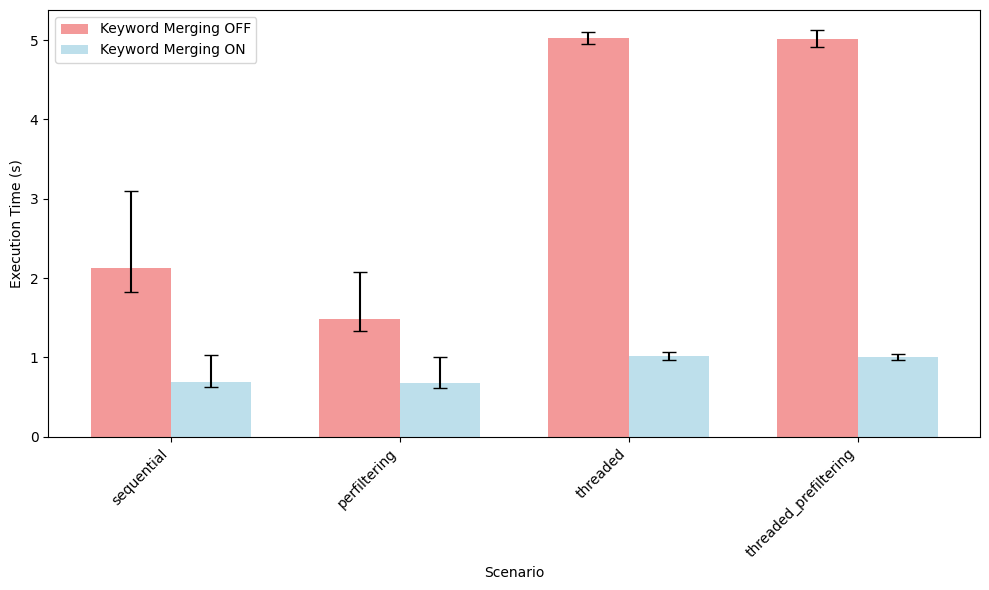

2025-07-04 14:36:26,073 - INFO - Saved keyword merging statistics to: figures/optimizer/csv_exports/keyword_merging_stats_20250704_143625.csv


In [14]:
# ========================================
# KEYWORD MERGING OPTIMIZATION ANALYSIS
# ========================================

logger.info("=== Keyword Merging Optimization Analysis ===")

# Filter for categories that involve keywords and multiple elements
keyword_categories = [
    "base_keyword_queries_with_multiple_elements",
]

# Check if optimizer_keyword_merging column exists
if "optimizer_keyword_merging" not in df_latest.columns:
    logger.warning(
        "optimizer_keyword_merging column not found in data - skipping keyword merging analysis"
    )
else:
    keyword_merging_stats = []

    # Filter data for keyword-related categories
    df_keywords = df_latest[df_latest["category"].isin(keyword_categories)]
    logger.info(f"Found {len(df_keywords)} records for keyword-related categories")

    if not df_keywords.empty:
        # Group by optimizer setting and scenario (ignoring fainder_mode)
        for category in keyword_categories:
            df_cat = df_keywords[df_keywords["category"] == category]
            if df_cat.empty:
                continue

            logger.info(f"Analyzing category: {category} ({len(df_cat)} records)")

            # Group by optimizer setting and scenario across all fainder modes
            comparison_data = []

            for kw_merging in df_cat["optimizer_keyword_merging"].unique():
                df_opt = df_cat[df_cat["optimizer_keyword_merging"] == kw_merging]

                for scenario in df_opt["scenario"].unique():
                    df_scenario = df_opt[df_opt["scenario"] == scenario]

                    if not df_scenario.empty:
                        mean_time = df_scenario["execution_time"].mean()
                        std_time = df_scenario["execution_time"].std()
                        min_time = df_scenario["execution_time"].min()
                        max_time = df_scenario["execution_time"].max()
                        count = len(df_scenario)

                        comparison_data.append(
                            {
                                "category": category,
                                "optimizer_keyword_merging": kw_merging,
                                "scenario": scenario,
                                "mean_execution_time": mean_time,
                                "std_execution_time": std_time,
                                "min_execution_time": min_time,
                                "max_execution_time": max_time,
                                "count": count,
                            }
                        )

                        keyword_merging_stats.append(
                            {
                                "category": category,
                                "optimizer_keyword_merging": kw_merging,
                                "scenario": scenario,
                                "mean": mean_time,
                                "std": std_time,
                                "min": min_time,
                                "max": max_time,
                                "count": count,
                            }
                        )

            if comparison_data:
                comparison_df = pd.DataFrame(comparison_data)

                # Create comparison plot
                fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

                # Create grouped bar plot
                scenarios = comparison_df["scenario"].unique()
                x = np.arange(len(scenarios))
                width = 0.35

                opt_on = comparison_df[
                    comparison_df["optimizer_keyword_merging"] == True
                ]
                opt_off = comparison_df[
                    comparison_df["optimizer_keyword_merging"] == False
                ]

                if not opt_on.empty and not opt_off.empty:
                    # Align data by scenario
                    on_means = [
                        opt_on[opt_on["scenario"] == s]["mean_execution_time"].iloc[
                            0
                        ]
                        if not opt_on[opt_on["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    off_means = [
                        opt_off[opt_off["scenario"] == s][
                            "mean_execution_time"
                        ].iloc[0]
                        if not opt_off[opt_off["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]

                    # Get min and max values for error bars
                    off_mins = [
                        opt_off[opt_off["scenario"] == s][
                            "min_execution_time"
                        ].iloc[0]
                        if not opt_off[opt_off["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    off_maxs = [
                        opt_off[opt_off["scenario"] == s][
                            "max_execution_time"
                        ].iloc[0]
                        if not opt_off[opt_off["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    on_mins = [
                        opt_on[opt_on["scenario"] == s]["min_execution_time"].iloc[
                            0
                        ]
                        if not opt_on[opt_on["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    on_maxs = [
                        opt_on[opt_on["scenario"] == s]["max_execution_time"].iloc[
                            0
                        ]
                        if not opt_on[opt_on["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]

                    # Calculate error bar arrays (lower_error, upper_error)
                    off_lower_err = [
                        mean - min_val for mean, min_val in zip(off_means, off_mins)
                    ]
                    off_upper_err = [
                        max_val - mean for mean, max_val in zip(off_means, off_maxs)
                    ]
                    on_lower_err = [
                        mean - min_val for mean, min_val in zip(on_means, on_mins)
                    ]
                    on_upper_err = [
                        max_val - mean for mean, max_val in zip(on_means, on_maxs)
                    ]

                    ax1.bar(
                        x - width / 2,
                        off_means,
                        width,
                        label="Keyword Merging OFF",
                        alpha=0.8,
                        yerr=[off_lower_err, off_upper_err],
                        capsize=5,
                        color="lightcoral",
                    )
                    ax1.bar(
                        x + width / 2,
                        on_means,
                        width,
                        label="Keyword Merging ON",
                        alpha=0.8,
                        yerr=[on_lower_err, on_upper_err],
                        capsize=5,
                        color="lightblue",
                    )

                    ax1.set_xlabel("Scenario")
                    ax1.set_ylabel("Execution Time (s)")
                    ax1.set_xticks(x)
                    ax1.set_xticklabels(scenarios, rotation=45, ha="right")
                    ax1.legend()

                    # Log performance improvement percentages (but don't plot them)
                    for i, scenario in enumerate(scenarios):
                        if on_means[i] > 0 and off_means[i] > 0:
                            improvement = (
                                (off_means[i] - on_means[i]) / off_means[i]
                            ) * 100
                            logger.info(
                                f"    {scenario}: {improvement:.2f}% improvement when ON"
                            )

                    plt.tight_layout()
                    filename = f"figures/optimizer/keyword_merging_{category}.png"
                    plt.savefig(filename)
                    logger.info(f"    Saved plot: {filename}")
                    plt.show()

    # Save keyword merging statistics
    if keyword_merging_stats:
        kw_stats_df = pd.DataFrame(keyword_merging_stats)
        kw_stats_file = csv_dir / f"keyword_merging_stats_{timestamp}.csv"
        kw_stats_df.to_csv(kw_stats_file, index=False)
        logger.info(f"Saved keyword merging statistics to: {kw_stats_file}")

2025-07-04 14:36:26,089 - INFO - === Cost Sorting Optimization Analysis ===
2025-07-04 14:36:26,091 - INFO - Found 1800 records for cost sorting-related categories
2025-07-04 14:36:26,092 - INFO - Analyzing category: Multiple_Percentile_Combinations (1800 records)
2025-07-04 14:36:26,093 - INFO -   Fainder mode: full_precision (900 records)
2025-07-04 14:36:26,091 - INFO - Found 1800 records for cost sorting-related categories
2025-07-04 14:36:26,092 - INFO - Analyzing category: Multiple_Percentile_Combinations (1800 records)
2025-07-04 14:36:26,093 - INFO -   Fainder mode: full_precision (900 records)
2025-07-04 14:36:26,122 - INFO -     sequential: 17.91% improvement when ON
2025-07-04 14:36:26,122 - INFO -     perfiltering: -258.64% improvement when ON
2025-07-04 14:36:26,123 - INFO -     threaded: 31.63% improvement when ON
2025-07-04 14:36:26,123 - INFO -     threaded_prefiltering: 30.42% improvement when ON
2025-07-04 14:36:26,122 - INFO -     sequential: 17.91% improvement when 

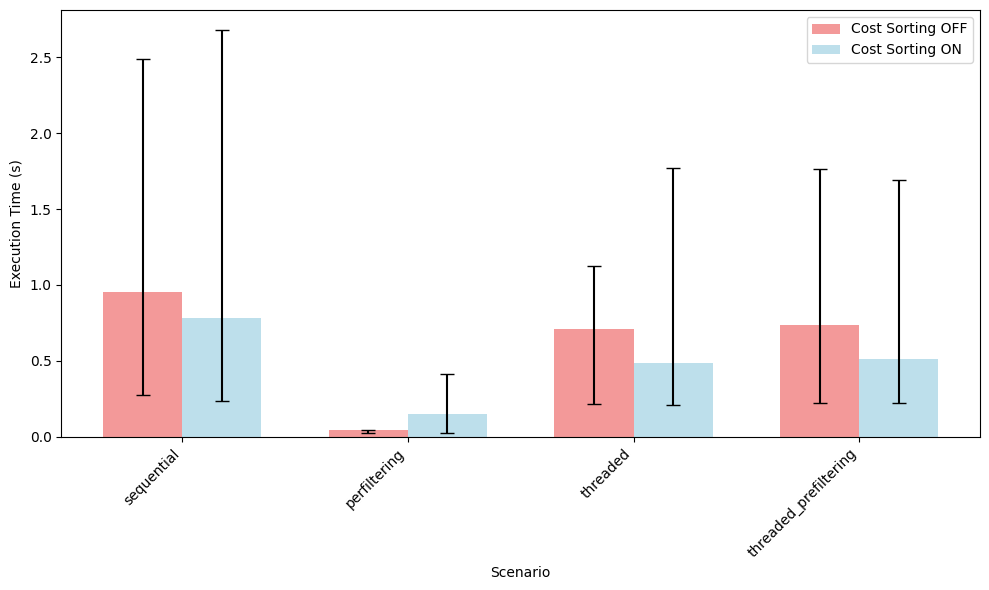

2025-07-04 14:36:26,251 - INFO -   Fainder mode: exact (900 records)
2025-07-04 14:36:26,279 - INFO -     sequential: 70.07% improvement when ON
2025-07-04 14:36:26,279 - INFO -     perfiltering: 56.69% improvement when ON
2025-07-04 14:36:26,280 - INFO -     threaded: 72.82% improvement when ON
2025-07-04 14:36:26,280 - INFO -     threaded_prefiltering: 73.77% improvement when ON
2025-07-04 14:36:26,279 - INFO -     sequential: 70.07% improvement when ON
2025-07-04 14:36:26,279 - INFO -     perfiltering: 56.69% improvement when ON
2025-07-04 14:36:26,280 - INFO -     threaded: 72.82% improvement when ON
2025-07-04 14:36:26,280 - INFO -     threaded_prefiltering: 73.77% improvement when ON
2025-07-04 14:36:26,351 - INFO -     Saved plot: figures/optimizer/cost_sorting_Multiple_Percentile_Combinations_exact.png
2025-07-04 14:36:26,351 - INFO -     Saved plot: figures/optimizer/cost_sorting_Multiple_Percentile_Combinations_exact.png


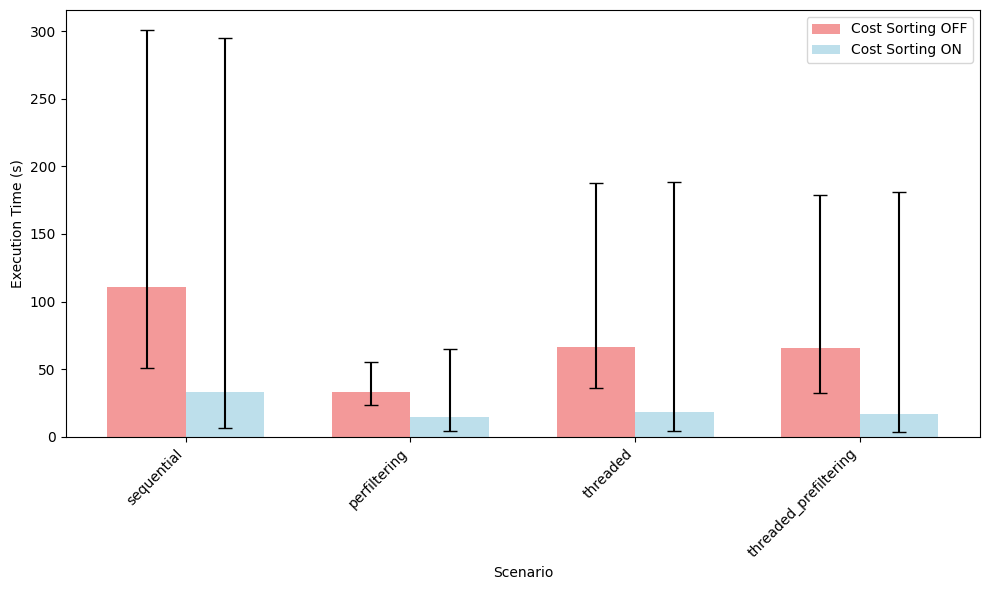

2025-07-04 14:36:26,404 - INFO - Saved cost sorting statistics to: figures/optimizer/csv_exports/cost_sorting_stats_20250704_143625.csv


In [15]:
# ========================================
# COST SORTING OPTIMIZATION ANALYSIS
# ========================================

logger.info("=== Cost Sorting Optimization Analysis ===")

# Filter for categories that involve multiple percentile combinations
cost_sorting_categories = [
    "Multiple_Percentile_Combinations",
]

# Check if optimizer_cost_sorting column exists
if "optimizer_cost_sorting" not in df_latest.columns:
    logger.warning(
        "optimizer_cost_sorting column not found in data - skipping cost sorting analysis"
    )
else:
    cost_sorting_stats = []

    # Filter data for percentile-related categories
    df_cost_sorting = df_latest[df_latest["category"].isin(cost_sorting_categories)]
    logger.info(
        f"Found {len(df_cost_sorting)} records for cost sorting-related categories"
    )

    if not df_cost_sorting.empty:
        # Create comprehensive comparison
        for category in cost_sorting_categories:
            df_cat = df_cost_sorting[df_cost_sorting["category"] == category]
            if df_cat.empty:
                continue

            logger.info(f"Analyzing category: {category} ({len(df_cat)} records)")

            # Create comparison plot for each fainder_mode
            for fainder_mode in df_cat["fainder_mode"].unique():
                df_mode = df_cat[df_cat["fainder_mode"] == fainder_mode]
                if df_mode.empty:
                    continue

                logger.info(f"  Fainder mode: {fainder_mode} ({len(df_mode)} records)")

                # Group by optimizer setting and scenario (assuming same number of workers)
                comparison_data = []

                for cost_sorting in df_mode["optimizer_cost_sorting"].unique():
                    df_opt = df_mode[df_mode["optimizer_cost_sorting"] == cost_sorting]

                    for scenario in df_opt["scenario"].unique():
                        df_scenario = df_opt[df_opt["scenario"] == scenario]

                        if not df_scenario.empty:
                            mean_time = df_scenario["execution_time"].mean()
                            std_time = df_scenario["execution_time"].std()
                            min_time = df_scenario["execution_time"].min()
                            max_time = df_scenario["execution_time"].max()
                            count = len(df_scenario)

                            comparison_data.append(
                                {
                                    "category": category,
                                    "fainder_mode": fainder_mode,
                                    "optimizer_cost_sorting": cost_sorting,
                                    "scenario": scenario,
                                    "mean_execution_time": mean_time,
                                    "std_execution_time": std_time,
                                    "min_execution_time": min_time,
                                    "max_execution_time": max_time,
                                    "count": count,
                                }
                            )

                            cost_sorting_stats.append(
                                {
                                    "category": category,
                                    "fainder_mode": fainder_mode,
                                    "optimizer_cost_sorting": cost_sorting,
                                    "scenario": scenario,
                                    "mean": mean_time,
                                    "std": std_time,
                                    "min": min_time,
                                    "max": max_time,
                                    "count": count,
                                }
                            )

                if comparison_data:
                    comparison_df = pd.DataFrame(comparison_data)

                    # Create comparison plot
                    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

                    # Create grouped bar plot
                    scenarios = comparison_df["scenario"].unique()
                    x = np.arange(len(scenarios))
                    width = 0.35

                    opt_on = comparison_df[
                        comparison_df["optimizer_cost_sorting"] == True
                    ]
                    opt_off = comparison_df[
                        comparison_df["optimizer_cost_sorting"] == False
                    ]

                    if not opt_on.empty and not opt_off.empty:
                        # Align data by scenario
                        on_means = [
                            opt_on[opt_on["scenario"] == s]["mean_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_means = [
                            opt_off[opt_off["scenario"] == s][
                                "mean_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Get min and max values for error bars
                        off_mins = [
                            opt_off[opt_off["scenario"] == s][
                                "min_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_maxs = [
                            opt_off[opt_off["scenario"] == s][
                                "max_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_mins = [
                            opt_on[opt_on["scenario"] == s]["min_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_maxs = [
                            opt_on[opt_on["scenario"] == s]["max_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Calculate error bar arrays (lower_error, upper_error)
                        off_lower_err = [
                            mean - min_val for mean, min_val in zip(off_means, off_mins)
                        ]
                        off_upper_err = [
                            max_val - mean for mean, max_val in zip(off_means, off_maxs)
                        ]
                        on_lower_err = [
                            mean - min_val for mean, min_val in zip(on_means, on_mins)
                        ]
                        on_upper_err = [
                            max_val - mean for mean, max_val in zip(on_means, on_maxs)
                        ]

                        ax1.bar(
                            x - width / 2,
                            off_means,
                            width,
                            label="Cost Sorting OFF",
                            alpha=0.8,
                            yerr=[off_lower_err, off_upper_err],
                            capsize=5,
                            color="lightcoral",
                        )
                        ax1.bar(
                            x + width / 2,
                            on_means,
                            width,
                            label="Cost Sorting ON",
                            alpha=0.8,
                            yerr=[on_lower_err, on_upper_err],
                            capsize=5,
                            color="lightblue",
                        )

                        ax1.set_xlabel("Scenario")
                        ax1.set_ylabel("Execution Time (s)")
                        ax1.set_xticks(x)
                        ax1.set_xticklabels(scenarios, rotation=45, ha="right")
                        ax1.legend()

                        # Log performance improvement percentages (but don't plot them)
                        for i, scenario in enumerate(scenarios):
                            if on_means[i] > 0 and off_means[i] > 0:
                                improvement = (
                                    (off_means[i] - on_means[i]) / off_means[i]
                                ) * 100
                                logger.info(
                                    f"    {scenario}: {improvement:.2f}% improvement when ON"
                                )

                        plt.tight_layout()
                        filename = f"figures/optimizer/cost_sorting_{category}_{fainder_mode}.png"
                        plt.savefig(filename)
                        logger.info(f"    Saved plot: {filename}")
                        plt.show()

    # Save cost sorting statistics
    if cost_sorting_stats:
        cost_stats_df = pd.DataFrame(cost_sorting_stats)
        cost_stats_file = csv_dir / f"cost_sorting_stats_{timestamp}.csv"
        cost_stats_df.to_csv(cost_stats_file, index=False)
        logger.info(f"Saved cost sorting statistics to: {cost_stats_file}")

2025-07-04 14:36:26,418 - INFO - === Split-up Junctions Optimization Analysis ===
2025-07-04 14:36:26,421 - INFO - Found 1800 records for junction-related categories
2025-07-04 14:36:26,422 - INFO - Analyzing category: Multiple_Percentile_Combinations (1800 records)
2025-07-04 14:36:26,423 - INFO -   Fainder mode: full_precision (900 records)
2025-07-04 14:36:26,421 - INFO - Found 1800 records for junction-related categories
2025-07-04 14:36:26,422 - INFO - Analyzing category: Multiple_Percentile_Combinations (1800 records)
2025-07-04 14:36:26,423 - INFO -   Fainder mode: full_precision (900 records)
2025-07-04 14:36:26,456 - INFO -     sequential: 3.22% improvement when ON
2025-07-04 14:36:26,457 - INFO -     perfiltering: 54.90% improvement when ON
2025-07-04 14:36:26,457 - INFO -     threaded: 8.27% improvement when ON
2025-07-04 14:36:26,457 - INFO -     threaded_prefiltering: 2.07% improvement when ON
2025-07-04 14:36:26,456 - INFO -     sequential: 3.22% improvement when ON
2025-

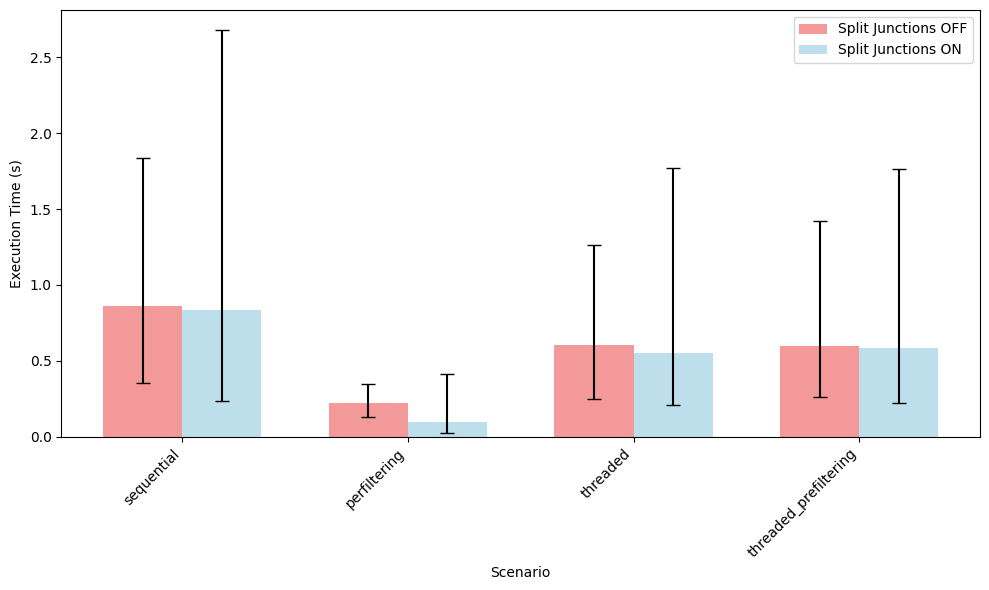

2025-07-04 14:36:26,594 - INFO -   Fainder mode: exact (900 records)
2025-07-04 14:36:26,623 - INFO -     sequential: 52.35% improvement when ON
2025-07-04 14:36:26,624 - INFO -     perfiltering: 52.76% improvement when ON
2025-07-04 14:36:26,624 - INFO -     threaded: 57.03% improvement when ON
2025-07-04 14:36:26,624 - INFO -     threaded_prefiltering: 57.56% improvement when ON
2025-07-04 14:36:26,623 - INFO -     sequential: 52.35% improvement when ON
2025-07-04 14:36:26,624 - INFO -     perfiltering: 52.76% improvement when ON
2025-07-04 14:36:26,624 - INFO -     threaded: 57.03% improvement when ON
2025-07-04 14:36:26,624 - INFO -     threaded_prefiltering: 57.56% improvement when ON
2025-07-04 14:36:26,693 - INFO -     Saved plot: figures/optimizer/split_junctions_Multiple_Percentile_Combinations_exact.png
2025-07-04 14:36:26,693 - INFO -     Saved plot: figures/optimizer/split_junctions_Multiple_Percentile_Combinations_exact.png


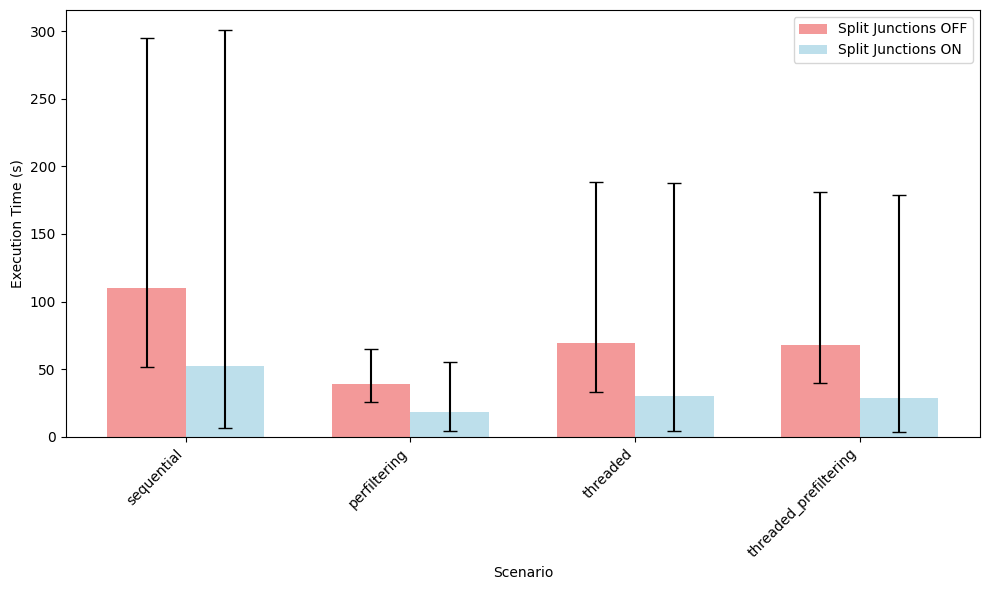

2025-07-04 14:36:26,755 - INFO - Saved split-up junctions statistics to: figures/optimizer/csv_exports/split_junctions_stats_20250704_143625.csv


In [16]:
# ========================================
# SPLIT-UP JUNCTIONS OPTIMIZATION ANALYSIS
# ========================================

logger.info("=== Split-up Junctions Optimization Analysis ===")

# Filter for categories that involve multiple percentile combinations (where junctions matter)
junction_categories = [
    "Multiple_Percentile_Combinations",
]

# Check if optimizer_split_up_junctions column exists
if "optimizer_split_up_junctions" not in df_latest.columns:
    logger.warning(
        "optimizer_split_up_junctions column not found in data - skipping split-up junctions analysis"
    )
else:
    junction_stats = []

    # Filter data for junction-related categories
    df_junctions = df_latest[df_latest["category"].isin(junction_categories)]
    logger.info(f"Found {len(df_junctions)} records for junction-related categories")

    if not df_junctions.empty:
        # Create comprehensive comparison
        for category in junction_categories:
            df_cat = df_junctions[df_junctions["category"] == category]
            if df_cat.empty:
                continue

            logger.info(f"Analyzing category: {category} ({len(df_cat)} records)")

            # Create comparison plot for each fainder_mode
            for fainder_mode in df_cat["fainder_mode"].unique():
                df_mode = df_cat[df_cat["fainder_mode"] == fainder_mode]
                if df_mode.empty:
                    continue

                logger.info(f"  Fainder mode: {fainder_mode} ({len(df_mode)} records)")

                # Group by optimizer setting and scenario
                comparison_data = []

                for split_junctions in df_mode["optimizer_split_up_junctions"].unique():
                    df_opt = df_mode[
                        df_mode["optimizer_split_up_junctions"] == split_junctions
                    ]

                    for scenario in df_opt["scenario"].unique():
                        df_scenario = df_opt[df_opt["scenario"] == scenario]

                        if not df_scenario.empty:
                            mean_time = df_scenario["execution_time"].mean()
                            std_time = df_scenario["execution_time"].std()
                            min_time = df_scenario["execution_time"].min()
                            max_time = df_scenario["execution_time"].max()
                            count = len(df_scenario)
                            median_time = df_scenario["execution_time"].median()

                            comparison_data.append(
                                {
                                    "category": category,
                                    "fainder_mode": fainder_mode,
                                    "optimizer_split_up_junctions": split_junctions,
                                    "scenario": scenario,
                                    "mean_execution_time": mean_time,
                                    "median_execution_time": median_time,
                                    "std_execution_time": std_time,
                                    "min_execution_time": min_time,
                                    "max_execution_time": max_time,
                                    "count": count,
                                }
                            )

                            junction_stats.append(
                                {
                                    "category": category,
                                    "fainder_mode": fainder_mode,
                                    "optimizer_split_up_junctions": split_junctions,
                                    "scenario": scenario,
                                    "mean": mean_time,
                                    "median": median_time,
                                    "std": std_time,
                                    "min": min_time,
                                    "max": max_time,
                                    "count": count,
                                }
                            )

                if comparison_data:
                    comparison_df = pd.DataFrame(comparison_data)

                    # Create comparison plot
                    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

                    # Bar plot comparison
                    scenarios = comparison_df["scenario"].unique()
                    x = np.arange(len(scenarios))
                    width = 0.35

                    opt_on = comparison_df[
                        comparison_df["optimizer_split_up_junctions"] == True
                    ]
                    opt_off = comparison_df[
                        comparison_df["optimizer_split_up_junctions"] == False
                    ]

                    if not opt_on.empty and not opt_off.empty:
                        # Align data by scenario
                        on_means = [
                            opt_on[opt_on["scenario"] == s]["mean_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_means = [
                            opt_off[opt_off["scenario"] == s][
                                "mean_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        on_stds = [
                            opt_on[opt_on["scenario"] == s]["std_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_stds = [
                            opt_off[opt_off["scenario"] == s][
                                "std_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Get min and max values for error bars
                        off_mins = [
                            opt_off[opt_off["scenario"] == s][
                                "min_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_maxs = [
                            opt_off[opt_off["scenario"] == s][
                                "max_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_mins = [
                            opt_on[opt_on["scenario"] == s]["min_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_maxs = [
                            opt_on[opt_on["scenario"] == s]["max_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Calculate error bar arrays (lower_error, upper_error)
                        off_lower_err = [
                            mean - min_val for mean, min_val in zip(off_means, off_mins)
                        ]
                        off_upper_err = [
                            max_val - mean for mean, max_val in zip(off_means, off_maxs)
                        ]
                        on_lower_err = [
                            mean - min_val for mean, min_val in zip(on_means, on_mins)
                        ]
                        on_upper_err = [
                            max_val - mean for mean, max_val in zip(on_means, on_maxs)
                        ]

                        ax1.bar(
                            x - width / 2,
                            off_means,
                            width,
                            label="Split Junctions OFF",
                            alpha=0.8,
                            yerr=[off_lower_err, off_upper_err],
                            capsize=5,
                            color="lightcoral",
                        )
                        ax1.bar(
                            x + width / 2,
                            on_means,
                            width,
                            label="Split Junctions ON",
                            alpha=0.8,
                            yerr=[on_lower_err, on_upper_err],
                            capsize=5,
                            color="lightblue",
                        )

                        ax1.set_xlabel("Scenario")
                        ax1.set_ylabel("Execution Time (s)")
                        ax1.set_xticks(x)
                        ax1.set_xticklabels(scenarios, rotation=45, ha="right")
                        ax1.legend()

                        # Log improvement percentages (but don't plot them)
                        for i, scenario in enumerate(scenarios):
                            if on_means[i] > 0 and off_means[i] > 0:
                                improvement = (
                                    (off_means[i] - on_means[i]) / off_means[i]
                                ) * 100
                                logger.info(
                                    f"    {scenario}: {improvement:.2f}% improvement when ON"
                                )

                        plt.tight_layout()
                        filename = f"figures/optimizer/split_junctions_{category}_{fainder_mode}.png"
                        plt.savefig(filename)
                        logger.info(f"    Saved plot: {filename}")
                        plt.show()

    # Save split-up junctions statistics
    if junction_stats:
        junction_stats_df = pd.DataFrame(junction_stats)
        junction_stats_file = csv_dir / f"split_junctions_stats_{timestamp}.csv"
        junction_stats_df.to_csv(junction_stats_file, index=False)
        logger.info(f"Saved split-up junctions statistics to: {junction_stats_file}")

# Alternative Analysis with Performance Improvement Percentages

The cells below contain the original analysis versions that include performance improvement percentage plots as the second subplot. You can run these instead of the above cells if you want to see the percentage improvements visualized.

2025-07-04 14:36:26,769 - INFO - === Keyword Merging Optimization Analysis (With Percentage Plots) ===
2025-07-04 14:36:26,771 - INFO - Found 88 records for keyword-related categories
2025-07-04 14:36:26,771 - INFO - Found 88 records for keyword-related categories
2025-07-04 14:36:26,772 - INFO - Analyzing category: base_keyword_queries_with_multiple_elements (88 records)
2025-07-04 14:36:26,803 - INFO -     sequential: 67.66% improvement when ON
2025-07-04 14:36:26,804 - INFO -     perfiltering: 54.08% improvement when ON
2025-07-04 14:36:26,805 - INFO -     threaded: 79.77% improvement when ON
2025-07-04 14:36:26,805 - INFO -     threaded_prefiltering: 79.89% improvement when ON
2025-07-04 14:36:26,772 - INFO - Analyzing category: base_keyword_queries_with_multiple_elements (88 records)
2025-07-04 14:36:26,803 - INFO -     sequential: 67.66% improvement when ON
2025-07-04 14:36:26,804 - INFO -     perfiltering: 54.08% improvement when ON
2025-07-04 14:36:26,805 - INFO -     threaded:

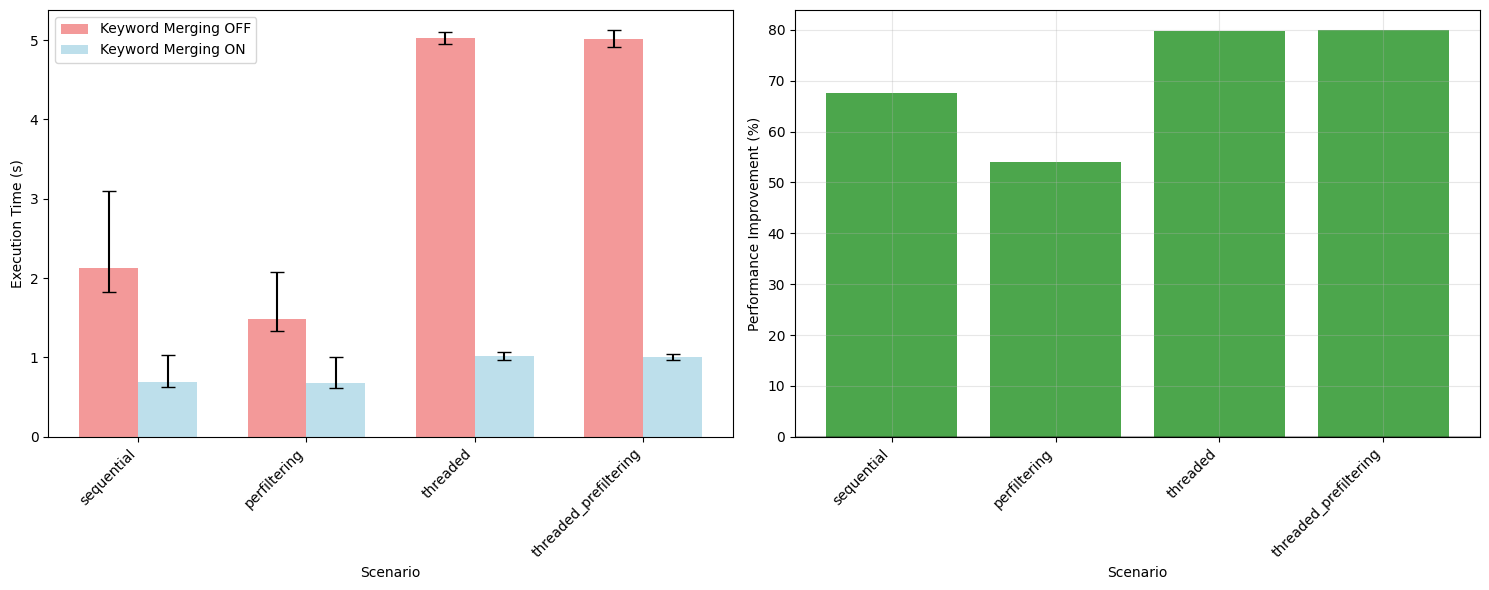

In [17]:
# ========================================
# KEYWORD MERGING OPTIMIZATION ANALYSIS (WITH PERCENTAGE PLOTS)
# ========================================

logger.info("=== Keyword Merging Optimization Analysis (With Percentage Plots) ===")

# Filter for categories that involve keywords and multiple elements
keyword_categories = [
    "base_keyword_queries_with_multiple_elements",
]

# Check if optimizer_keyword_merging column exists
if "optimizer_keyword_merging" not in df_latest.columns:
    logger.warning(
        "optimizer_keyword_merging column not found in data - skipping keyword merging analysis"
    )
else:
    keyword_merging_stats = []

    # Filter data for keyword-related categories
    df_keywords = df_latest[df_latest["category"].isin(keyword_categories)]
    logger.info(f"Found {len(df_keywords)} records for keyword-related categories")

    if not df_keywords.empty:
        # Group by optimizer setting and scenario (ignoring fainder_mode)
        for category in keyword_categories:
            df_cat = df_keywords[df_keywords["category"] == category]
            if df_cat.empty:
                continue

            logger.info(f"Analyzing category: {category} ({len(df_cat)} records)")

            # Group by optimizer setting and scenario across all fainder modes
            comparison_data = []

            for kw_merging in df_cat["optimizer_keyword_merging"].unique():
                df_opt = df_cat[df_cat["optimizer_keyword_merging"] == kw_merging]

                for scenario in df_opt["scenario"].unique():
                    df_scenario = df_opt[df_opt["scenario"] == scenario]

                    if not df_scenario.empty:
                        mean_time = df_scenario["execution_time"].mean()
                        std_time = df_scenario["execution_time"].std()
                        min_time = df_scenario["execution_time"].min()
                        max_time = df_scenario["execution_time"].max()
                        count = len(df_scenario)

                        comparison_data.append(
                            {
                                "category": category,
                                "optimizer_keyword_merging": kw_merging,
                                "scenario": scenario,
                                "mean_execution_time": mean_time,
                                "std_execution_time": std_time,
                                "min_execution_time": min_time,
                                "max_execution_time": max_time,
                                "count": count,
                            }
                        )

                        keyword_merging_stats.append(
                            {
                                "category": category,
                                "optimizer_keyword_merging": kw_merging,
                                "scenario": scenario,
                                "mean": mean_time,
                                "std": std_time,
                                "min": min_time,
                                "max": max_time,
                                "count": count,
                            }
                        )

            if comparison_data:
                comparison_df = pd.DataFrame(comparison_data)

                # Create comparison plots
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

                # Create grouped bar plot
                scenarios = comparison_df["scenario"].unique()
                x = np.arange(len(scenarios))
                width = 0.35

                opt_on = comparison_df[
                    comparison_df["optimizer_keyword_merging"] == True
                ]
                opt_off = comparison_df[
                    comparison_df["optimizer_keyword_merging"] == False
                ]

                if not opt_on.empty and not opt_off.empty:
                    # Align data by scenario
                    on_means = [
                        opt_on[opt_on["scenario"] == s]["mean_execution_time"].iloc[
                            0
                        ]
                        if not opt_on[opt_on["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    off_means = [
                        opt_off[opt_off["scenario"] == s][
                            "mean_execution_time"
                        ].iloc[0]
                        if not opt_off[opt_off["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]

                    # Get min and max values for error bars
                    off_mins = [
                        opt_off[opt_off["scenario"] == s][
                            "min_execution_time"
                        ].iloc[0]
                        if not opt_off[opt_off["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    off_maxs = [
                        opt_off[opt_off["scenario"] == s][
                            "max_execution_time"
                        ].iloc[0]
                        if not opt_off[opt_off["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    on_mins = [
                        opt_on[opt_on["scenario"] == s]["min_execution_time"].iloc[
                            0
                        ]
                        if not opt_on[opt_on["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]
                    on_maxs = [
                        opt_on[opt_on["scenario"] == s]["max_execution_time"].iloc[
                            0
                        ]
                        if not opt_on[opt_on["scenario"] == s].empty
                        else 0
                        for s in scenarios
                    ]

                    # Calculate error bar arrays (lower_error, upper_error)
                    off_lower_err = [
                        mean - min_val for mean, min_val in zip(off_means, off_mins)
                    ]
                    off_upper_err = [
                        max_val - mean for mean, max_val in zip(off_means, off_maxs)
                    ]
                    on_lower_err = [
                        mean - min_val for mean, min_val in zip(on_means, on_mins)
                    ]
                    on_upper_err = [
                        max_val - mean for mean, max_val in zip(on_means, on_maxs)
                    ]

                    ax1.bar(
                        x - width / 2,
                        off_means,
                        width,
                        label="Keyword Merging OFF",
                        alpha=0.8,
                        yerr=[off_lower_err, off_upper_err],
                        capsize=5,
                        color="lightcoral",
                    )
                    ax1.bar(
                        x + width / 2,
                        on_means,
                        width,
                        label="Keyword Merging ON",
                        alpha=0.8,
                        yerr=[on_lower_err, on_upper_err],
                        capsize=5,
                        color="lightblue",
                    )

                    ax1.set_xlabel("Scenario")
                    ax1.set_ylabel("Execution Time (s)")
                    ax1.set_xticks(x)
                    ax1.set_xticklabels(scenarios, rotation=45, ha="right")
                    ax1.legend()

                    # Performance improvement percentages
                    improvements = []
                    scenario_labels = []
                    for i, scenario in enumerate(scenarios):
                        if on_means[i] > 0 and off_means[i] > 0:
                            improvement = (
                                (off_means[i] - on_means[i]) / off_means[i]
                            ) * 100
                            improvements.append(improvement)
                            scenario_labels.append(scenario)
                            logger.info(
                                f"    {scenario}: {improvement:.2f}% improvement when ON"
                            )

                    if improvements:
                        colors = [
                            "green" if imp > 0 else "red" for imp in improvements
                        ]
                        ax2.bar(
                            range(len(improvements)),
                            improvements,
                            color=colors,
                            alpha=0.7,
                        )
                        ax2.set_xlabel("Scenario")
                        ax2.set_ylabel("Performance Improvement (%)")
                        ax2.set_xticks(range(len(scenario_labels)))
                        ax2.set_xticklabels(
                            scenario_labels, rotation=45, ha="right"
                        )
                        ax2.axhline(y=0, color="black", linestyle="-", alpha=0.3)
                        ax2.grid(True, alpha=0.3)

                    plt.tight_layout()
                    filename = f"figures/optimizer/keyword_merging_with_pct_{category}.png"
                    plt.savefig(filename)
                    logger.info(f"    Saved plot: {filename}")
                    plt.show()

2025-07-04 14:36:27,074 - INFO - === Cost Sorting Optimization Analysis (With Percentage Plots) ===
2025-07-04 14:36:27,078 - INFO - Found 1800 records for cost sorting-related categories
2025-07-04 14:36:27,079 - INFO - Analyzing category: Multiple_Percentile_Combinations (1800 records)
2025-07-04 14:36:27,080 - INFO -   Fainder mode: full_precision (900 records)
2025-07-04 14:36:27,078 - INFO - Found 1800 records for cost sorting-related categories
2025-07-04 14:36:27,079 - INFO - Analyzing category: Multiple_Percentile_Combinations (1800 records)
2025-07-04 14:36:27,080 - INFO -   Fainder mode: full_precision (900 records)
2025-07-04 14:36:27,113 - INFO -     sequential: 17.91% improvement when ON
2025-07-04 14:36:27,114 - INFO -     perfiltering: -258.64% improvement when ON
2025-07-04 14:36:27,114 - INFO -     threaded: 31.63% improvement when ON
2025-07-04 14:36:27,115 - INFO -     threaded_prefiltering: 30.42% improvement when ON
2025-07-04 14:36:27,113 - INFO -     sequential: 

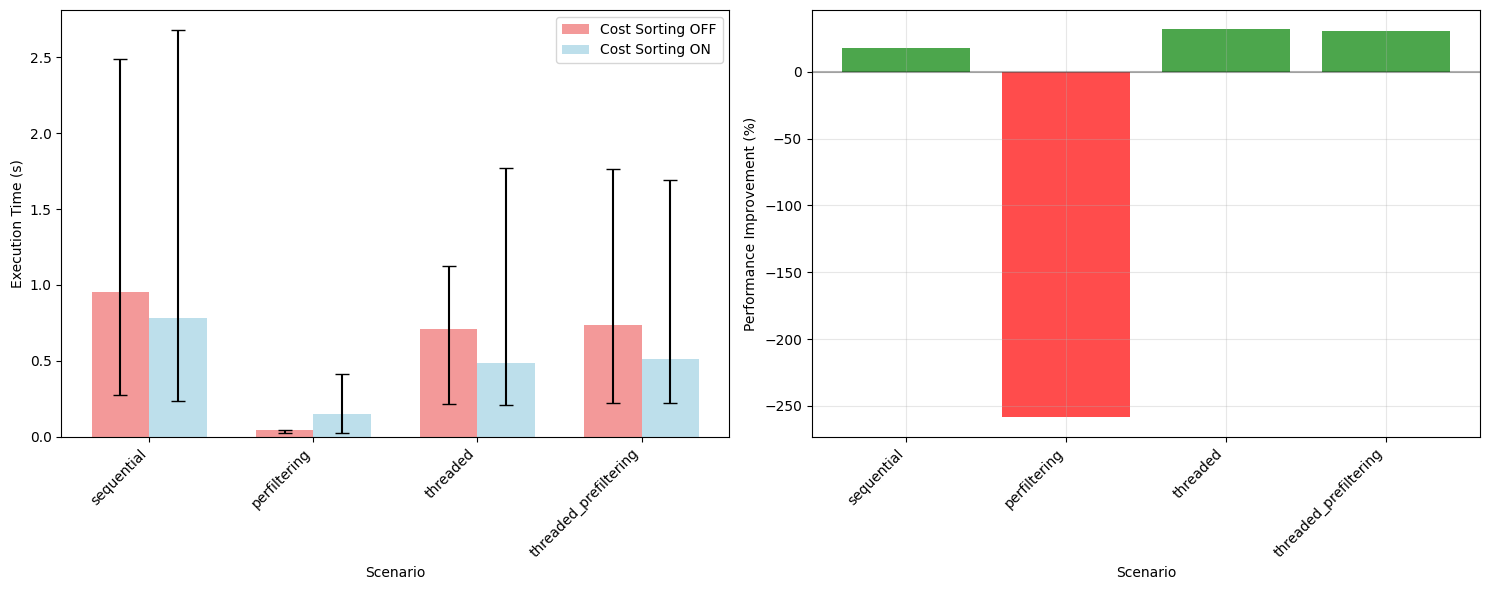

2025-07-04 14:36:27,319 - INFO -   Fainder mode: exact (900 records)
2025-07-04 14:36:27,345 - INFO -     sequential: 70.07% improvement when ON
2025-07-04 14:36:27,346 - INFO -     perfiltering: 56.69% improvement when ON
2025-07-04 14:36:27,346 - INFO -     threaded: 72.82% improvement when ON
2025-07-04 14:36:27,347 - INFO -     threaded_prefiltering: 73.77% improvement when ON
2025-07-04 14:36:27,345 - INFO -     sequential: 70.07% improvement when ON
2025-07-04 14:36:27,346 - INFO -     perfiltering: 56.69% improvement when ON
2025-07-04 14:36:27,346 - INFO -     threaded: 72.82% improvement when ON
2025-07-04 14:36:27,347 - INFO -     threaded_prefiltering: 73.77% improvement when ON
2025-07-04 14:36:27,472 - INFO -     Saved plot: figures/optimizer/cost_sorting_with_pct_Multiple_Percentile_Combinations_exact.png
2025-07-04 14:36:27,472 - INFO -     Saved plot: figures/optimizer/cost_sorting_with_pct_Multiple_Percentile_Combinations_exact.png


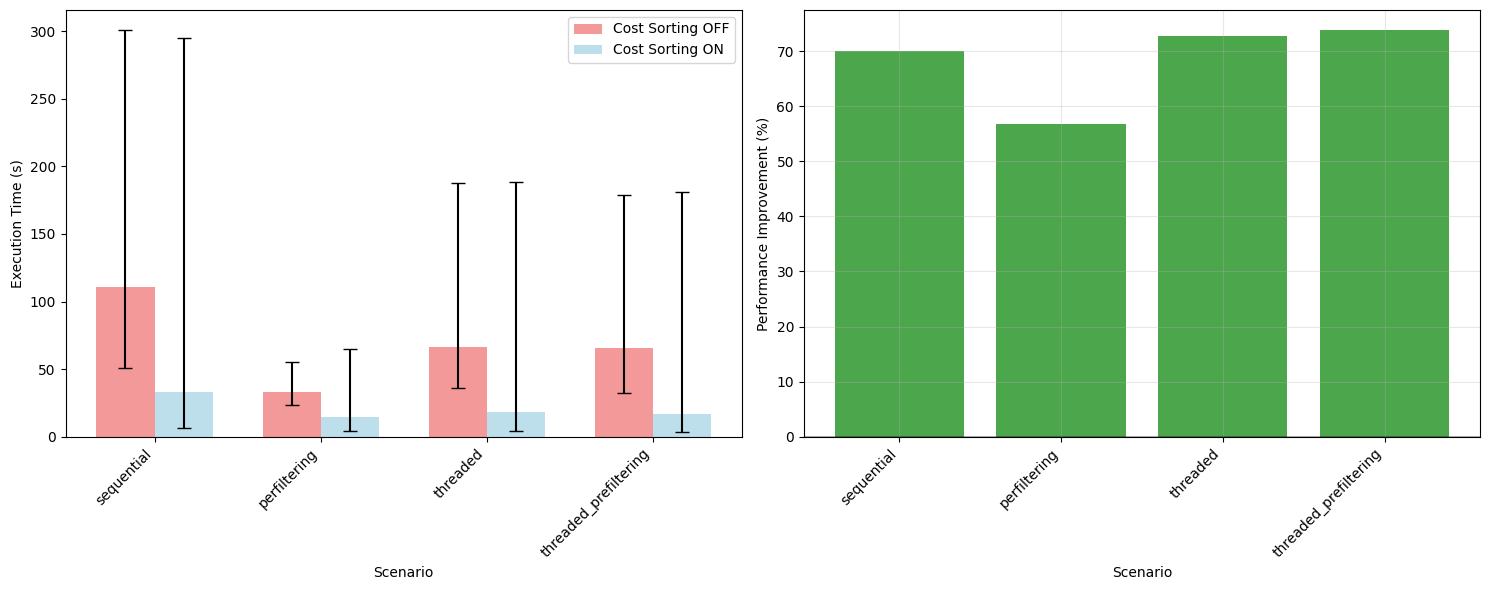

In [18]:
# ========================================
# COST SORTING OPTIMIZATION ANALYSIS (WITH PERCENTAGE PLOTS)
# ========================================

logger.info("=== Cost Sorting Optimization Analysis (With Percentage Plots) ===")

# Filter for categories that involve multiple percentile combinations
cost_sorting_categories = [
    "Multiple_Percentile_Combinations",
]

# Check if optimizer_cost_sorting column exists
if "optimizer_cost_sorting" not in df_latest.columns:
    logger.warning(
        "optimizer_cost_sorting column not found in data - skipping cost sorting analysis"
    )
else:
    cost_sorting_stats = []

    # Filter data for percentile-related categories
    df_cost_sorting = df_latest[df_latest["category"].isin(cost_sorting_categories)]
    logger.info(
        f"Found {len(df_cost_sorting)} records for cost sorting-related categories"
    )

    if not df_cost_sorting.empty:
        # Create comprehensive comparison
        for category in cost_sorting_categories:
            df_cat = df_cost_sorting[df_cost_sorting["category"] == category]
            if df_cat.empty:
                continue

            logger.info(f"Analyzing category: {category} ({len(df_cat)} records)")

            # Create comparison plot for each fainder_mode
            for fainder_mode in df_cat["fainder_mode"].unique():
                df_mode = df_cat[df_cat["fainder_mode"] == fainder_mode]
                if df_mode.empty:
                    continue

                logger.info(f"  Fainder mode: {fainder_mode} ({len(df_mode)} records)")

                # Group by optimizer setting and scenario (assuming same number of workers)
                comparison_data = []

                for cost_sorting in df_mode["optimizer_cost_sorting"].unique():
                    df_opt = df_mode[df_mode["optimizer_cost_sorting"] == cost_sorting]

                    for scenario in df_opt["scenario"].unique():
                        df_scenario = df_opt[df_opt["scenario"] == scenario]

                        if not df_scenario.empty:
                            mean_time = df_scenario["execution_time"].mean()
                            std_time = df_scenario["execution_time"].std()
                            min_time = df_scenario["execution_time"].min()
                            max_time = df_scenario["execution_time"].max()
                            count = len(df_scenario)

                            comparison_data.append(
                                {
                                    "category": category,
                                    "fainder_mode": fainder_mode,
                                    "optimizer_cost_sorting": cost_sorting,
                                    "scenario": scenario,
                                    "mean_execution_time": mean_time,
                                    "std_execution_time": std_time,
                                    "min_execution_time": min_time,
                                    "max_execution_time": max_time,
                                    "count": count,
                                }
                            )

                if comparison_data:
                    comparison_df = pd.DataFrame(comparison_data)

                    # Create comparison plots
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

                    # Create grouped bar plot
                    scenarios = comparison_df["scenario"].unique()
                    x = np.arange(len(scenarios))
                    width = 0.35

                    opt_on = comparison_df[
                        comparison_df["optimizer_cost_sorting"] == True
                    ]
                    opt_off = comparison_df[
                        comparison_df["optimizer_cost_sorting"] == False
                    ]

                    if not opt_on.empty and not opt_off.empty:
                        # Align data by scenario
                        on_means = [
                            opt_on[opt_on["scenario"] == s]["mean_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_means = [
                            opt_off[opt_off["scenario"] == s][
                                "mean_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Get min and max values for error bars
                        off_mins = [
                            opt_off[opt_off["scenario"] == s][
                                "min_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_maxs = [
                            opt_off[opt_off["scenario"] == s][
                                "max_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_mins = [
                            opt_on[opt_on["scenario"] == s]["min_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_maxs = [
                            opt_on[opt_on["scenario"] == s]["max_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Calculate error bar arrays (lower_error, upper_error)
                        off_lower_err = [
                            mean - min_val for mean, min_val in zip(off_means, off_mins)
                        ]
                        off_upper_err = [
                            max_val - mean for mean, max_val in zip(off_means, off_maxs)
                        ]
                        on_lower_err = [
                            mean - min_val for mean, min_val in zip(on_means, on_mins)
                        ]
                        on_upper_err = [
                            max_val - mean for mean, max_val in zip(on_means, on_maxs)
                        ]

                        ax1.bar(
                            x - width / 2,
                            off_means,
                            width,
                            label="Cost Sorting OFF",
                            alpha=0.8,
                            yerr=[off_lower_err, off_upper_err],
                            capsize=5,
                            color="lightcoral",
                        )
                        ax1.bar(
                            x + width / 2,
                            on_means,
                            width,
                            label="Cost Sorting ON",
                            alpha=0.8,
                            yerr=[on_lower_err, on_upper_err],
                            capsize=5,
                            color="lightblue",
                        )

                        ax1.set_xlabel("Scenario")
                        ax1.set_ylabel("Execution Time (s)")
                        ax1.set_xticks(x)
                        ax1.set_xticklabels(scenarios, rotation=45, ha="right")
                        ax1.legend()

                        # Performance improvement percentages
                        improvements = []
                        scenario_labels = []
                        for i, scenario in enumerate(scenarios):
                            if on_means[i] > 0 and off_means[i] > 0:
                                improvement = (
                                    (off_means[i] - on_means[i]) / off_means[i]
                                ) * 100
                                improvements.append(improvement)
                                scenario_labels.append(scenario)
                                logger.info(
                                    f"    {scenario}: {improvement:.2f}% improvement when ON"
                                )

                        if improvements:
                            colors = [
                                "green" if imp > 0 else "red" for imp in improvements
                            ]
                            ax2.bar(
                                range(len(improvements)),
                                improvements,
                                color=colors,
                                alpha=0.7,
                            )
                            ax2.set_xlabel("Scenario")
                            ax2.set_ylabel("Performance Improvement (%)")
                            ax2.set_xticks(range(len(scenario_labels)))
                            ax2.set_xticklabels(
                                scenario_labels, rotation=45, ha="right"
                            )
                            ax2.axhline(y=0, color="black", linestyle="-", alpha=0.3)
                            ax2.grid(True, alpha=0.3)

                        plt.tight_layout()
                        filename = f"figures/optimizer/cost_sorting_with_pct_{category}_{fainder_mode}.png"
                        plt.savefig(filename)
                        logger.info(f"    Saved plot: {filename}")
                        plt.show()

2025-07-04 14:36:27,582 - INFO - === Split-up Junctions Optimization Analysis (With Percentage Plots) ===
2025-07-04 14:36:27,585 - INFO - Found 1800 records for junction-related categories
2025-07-04 14:36:27,586 - INFO - Analyzing category: Multiple_Percentile_Combinations (1800 records)
2025-07-04 14:36:27,587 - INFO -   Fainder mode: full_precision (900 records)
2025-07-04 14:36:27,585 - INFO - Found 1800 records for junction-related categories
2025-07-04 14:36:27,586 - INFO - Analyzing category: Multiple_Percentile_Combinations (1800 records)
2025-07-04 14:36:27,587 - INFO -   Fainder mode: full_precision (900 records)
2025-07-04 14:36:27,620 - INFO -     sequential: 3.22% improvement when ON
2025-07-04 14:36:27,621 - INFO -     perfiltering: 54.90% improvement when ON
2025-07-04 14:36:27,621 - INFO -     threaded: 8.27% improvement when ON
2025-07-04 14:36:27,622 - INFO -     threaded_prefiltering: 2.07% improvement when ON
2025-07-04 14:36:27,620 - INFO -     sequential: 3.22% i

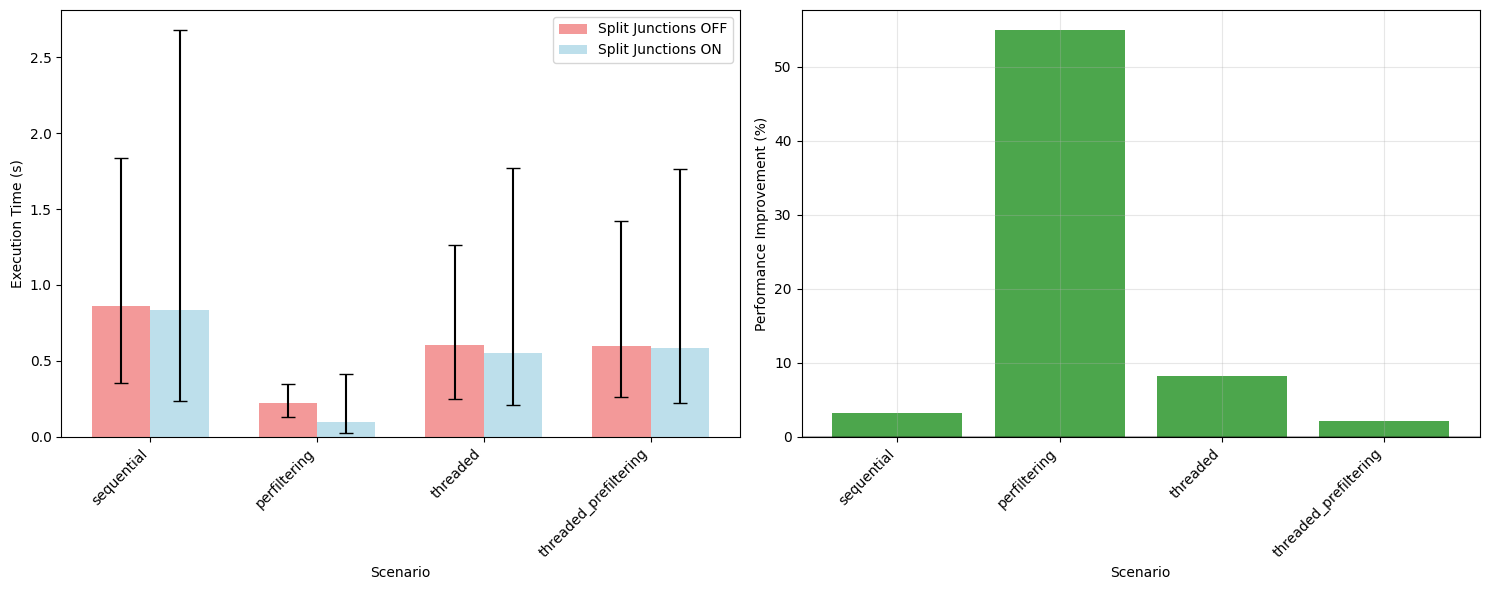

2025-07-04 14:36:27,834 - INFO -   Fainder mode: exact (900 records)
2025-07-04 14:36:27,862 - INFO -     sequential: 52.35% improvement when ON
2025-07-04 14:36:27,862 - INFO -     perfiltering: 52.76% improvement when ON
2025-07-04 14:36:27,862 - INFO -     threaded: 57.03% improvement when ON
2025-07-04 14:36:27,863 - INFO -     threaded_prefiltering: 57.56% improvement when ON
2025-07-04 14:36:27,862 - INFO -     sequential: 52.35% improvement when ON
2025-07-04 14:36:27,862 - INFO -     perfiltering: 52.76% improvement when ON
2025-07-04 14:36:27,862 - INFO -     threaded: 57.03% improvement when ON
2025-07-04 14:36:27,863 - INFO -     threaded_prefiltering: 57.56% improvement when ON
2025-07-04 14:36:28,056 - INFO -     Saved plot: figures/optimizer/split_junctions_with_pct_Multiple_Percentile_Combinations_exact.png
2025-07-04 14:36:28,056 - INFO -     Saved plot: figures/optimizer/split_junctions_with_pct_Multiple_Percentile_Combinations_exact.png


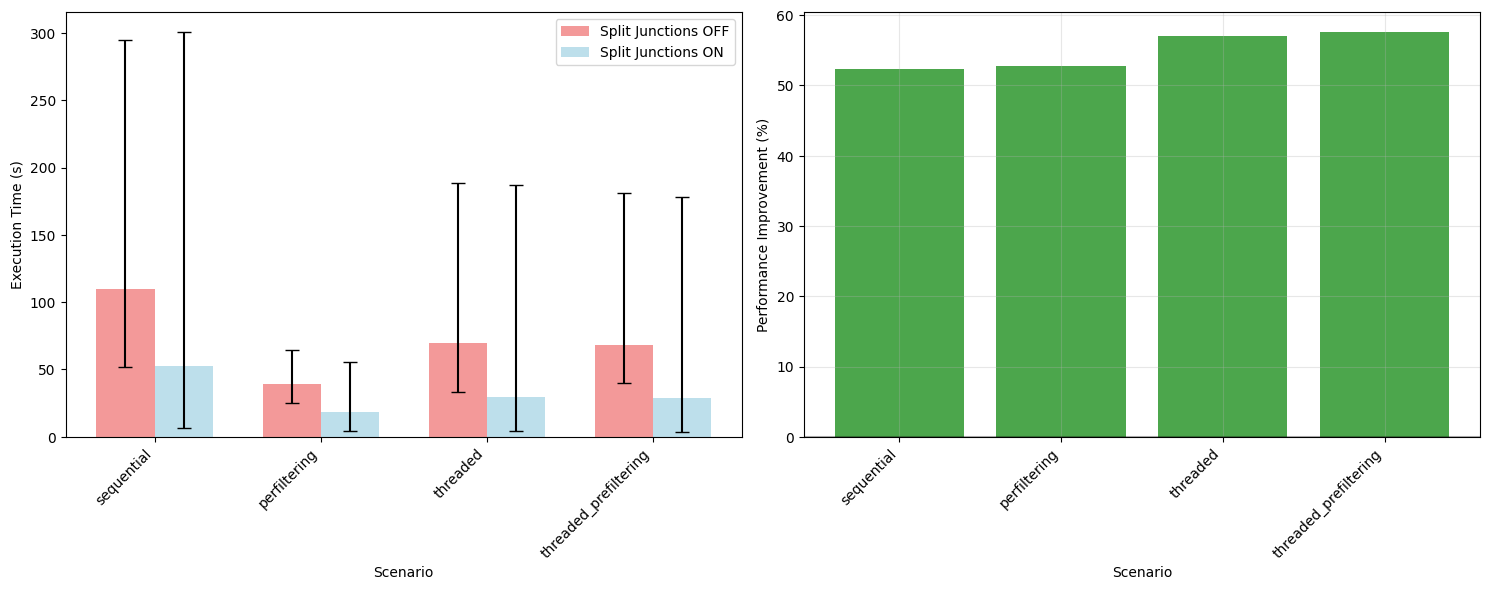

In [19]:
# ========================================
# SPLIT-UP JUNCTIONS OPTIMIZATION ANALYSIS (WITH PERCENTAGE PLOTS)
# ========================================

logger.info("=== Split-up Junctions Optimization Analysis (With Percentage Plots) ===")

# Filter for categories that involve multiple percentile combinations (where junctions matter)
junction_categories = [
    "Multiple_Percentile_Combinations",
]

# Check if optimizer_split_up_junctions column exists
if "optimizer_split_up_junctions" not in df_latest.columns:
    logger.warning(
        "optimizer_split_up_junctions column not found in data - skipping split-up junctions analysis"
    )
else:
    junction_stats = []

    # Filter data for junction-related categories
    df_junctions = df_latest[df_latest["category"].isin(junction_categories)]
    logger.info(f"Found {len(df_junctions)} records for junction-related categories")

    if not df_junctions.empty:
        # Create comprehensive comparison
        for category in junction_categories:
            df_cat = df_junctions[df_junctions["category"] == category]
            if df_cat.empty:
                continue

            logger.info(f"Analyzing category: {category} ({len(df_cat)} records)")

            # Create comparison plot for each fainder_mode
            for fainder_mode in df_cat["fainder_mode"].unique():
                df_mode = df_cat[df_cat["fainder_mode"] == fainder_mode]
                if df_mode.empty:
                    continue

                logger.info(f"  Fainder mode: {fainder_mode} ({len(df_mode)} records)")

                # Group by optimizer setting and scenario
                comparison_data = []

                for split_junctions in df_mode["optimizer_split_up_junctions"].unique():
                    df_opt = df_mode[
                        df_mode["optimizer_split_up_junctions"] == split_junctions
                    ]

                    for scenario in df_opt["scenario"].unique():
                        df_scenario = df_opt[df_opt["scenario"] == scenario]

                        if not df_scenario.empty:
                            mean_time = df_scenario["execution_time"].mean()
                            std_time = df_scenario["execution_time"].std()
                            min_time = df_scenario["execution_time"].min()
                            max_time = df_scenario["execution_time"].max()
                            count = len(df_scenario)
                            median_time = df_scenario["execution_time"].median()

                            comparison_data.append(
                                {
                                    "category": category,
                                    "fainder_mode": fainder_mode,
                                    "optimizer_split_up_junctions": split_junctions,
                                    "scenario": scenario,
                                    "mean_execution_time": mean_time,
                                    "median_execution_time": median_time,
                                    "std_execution_time": std_time,
                                    "min_execution_time": min_time,
                                    "max_execution_time": max_time,
                                    "count": count,
                                }
                            )

                if comparison_data:
                    comparison_df = pd.DataFrame(comparison_data)

                    # Create comparison plots
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

                    # Bar plot comparison
                    scenarios = comparison_df["scenario"].unique()
                    x = np.arange(len(scenarios))
                    width = 0.35

                    opt_on = comparison_df[
                        comparison_df["optimizer_split_up_junctions"] == True
                    ]
                    opt_off = comparison_df[
                        comparison_df["optimizer_split_up_junctions"] == False
                    ]

                    if not opt_on.empty and not opt_off.empty:
                        # Align data by scenario
                        on_means = [
                            opt_on[opt_on["scenario"] == s]["mean_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_means = [
                            opt_off[opt_off["scenario"] == s][
                                "mean_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Get min and max values for error bars
                        off_mins = [
                            opt_off[opt_off["scenario"] == s][
                                "min_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        off_maxs = [
                            opt_off[opt_off["scenario"] == s][
                                "max_execution_time"
                            ].iloc[0]
                            if not opt_off[opt_off["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_mins = [
                            opt_on[opt_on["scenario"] == s]["min_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]
                        on_maxs = [
                            opt_on[opt_on["scenario"] == s]["max_execution_time"].iloc[
                                0
                            ]
                            if not opt_on[opt_on["scenario"] == s].empty
                            else 0
                            for s in scenarios
                        ]

                        # Calculate error bar arrays (lower_error, upper_error)
                        off_lower_err = [
                            mean - min_val for mean, min_val in zip(off_means, off_mins)
                        ]
                        off_upper_err = [
                            max_val - mean for mean, max_val in zip(off_means, off_maxs)
                        ]
                        on_lower_err = [
                            mean - min_val for mean, min_val in zip(on_means, on_mins)
                        ]
                        on_upper_err = [
                            max_val - mean for mean, max_val in zip(on_means, on_maxs)
                        ]

                        ax1.bar(
                            x - width / 2,
                            off_means,
                            width,
                            label="Split Junctions OFF",
                            alpha=0.8,
                            yerr=[off_lower_err, off_upper_err],
                            capsize=5,
                            color="lightcoral",
                        )
                        ax1.bar(
                            x + width / 2,
                            on_means,
                            width,
                            label="Split Junctions ON",
                            alpha=0.8,
                            yerr=[on_lower_err, on_upper_err],
                            capsize=5,
                            color="lightblue",
                        )

                        ax1.set_xlabel("Scenario")
                        ax1.set_ylabel("Execution Time (s)")
                        ax1.set_xticks(x)
                        ax1.set_xticklabels(scenarios, rotation=45, ha="right")
                        ax1.legend()

                        # Improvement percentages
                        improvements = []
                        scenario_labels = []
                        for i, scenario in enumerate(scenarios):
                            if on_means[i] > 0 and off_means[i] > 0:
                                improvement = (
                                    (off_means[i] - on_means[i]) / off_means[i]
                                ) * 100
                                improvements.append(improvement)
                                scenario_labels.append(scenario)
                                logger.info(
                                    f"    {scenario}: {improvement:.2f}% improvement when ON"
                                )

                        if improvements:
                            colors = [
                                "green" if imp > 0 else "red" for imp in improvements
                            ]
                            ax2.bar(
                                range(len(improvements)),
                                improvements,
                                color=colors,
                                alpha=0.7,
                            )
                            ax2.set_xlabel("Scenario")
                            ax2.set_ylabel("Performance Improvement (%)")
                            ax2.set_xticks(range(len(scenario_labels)))
                            ax2.set_xticklabels(
                                scenario_labels, rotation=45, ha="right"
                            )
                            ax2.axhline(y=0, color="black", linestyle="-", alpha=0.3)
                            ax2.grid(True, alpha=0.3)

                        plt.tight_layout()
                        filename = f"figures/optimizer/split_junctions_with_pct_{category}_{fainder_mode}.png"
                        plt.savefig(filename)
                        logger.info(f"    Saved plot: {filename}")
                        plt.show()